In [ ]:
from gekko import GEKKO
import numpy
import matplotlib.pyplot as plt

In [56]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize Model
m = GEKKO()

# Define constants

#Reflux Ratio
rr=m.Param(value=0.7)

# Feed flowrate (mol/min)
Feed1=m.Const(value=30/46)
Feed2=m.Const(value=40/46)

# Mole fraction of feed
x_Feed=m.Const(value=.4)

#Relative volatility = (yA/xA)/(yB/xB) = KA/KB = alpha(A,B)
vol=m.Const(value=1.4)

# Total molar holdup on each tray
atray=m.Const(value=.3)

# Total molar holdup in condenser
acond=m.Const(value=.8)

# Total molar holdup in reboiler
areb=m.Const(value=.8)

# mole fraction of component A
x=[]
for i in range(12):
    x.append(m.Var(.3))

# Define intermediates

# Distillate flowrate (mol/min)
D=m.Intermediate(.5*(Feed1+Feed2))

# Liquid flowrate in rectification section (mol/min)
L=m.Intermediate(rr*D)

# Vapor Flowrate in column (mol/min)
V=m.Intermediate(L+D)

# Liquid flowrate in stripping section (mol/min)
FL1=m.Intermediate(Feed1+L)
FL2=m.Intermediate(FL1+Feed2)

# vapor mole fraction of Component A
# From the equilibrium assumption and mole balances
# 1) vol = (yA/xA) / (yB/xB)
# 2) xA + xB = 1
# 3) yA + yB = 1
y=[]
for i in range(12):
    y.append(m.Intermediate(x[i]*vol/(1+(vol-1)*x[i])))

# condenser
m.Equation(acond*x[0].dt()==V*(y[1]-x[0]))

# 2 column stages
n=1
for i in range(2):
    m.Equation(atray * x[n].dt() ==L*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1

# feed tray 3
m.Equation(atray * x[3].dt() == Feed1*x_Feed + L*x[2] - FL1*x[3] - V*(y[3]-y[4]))

# 3 column stages
n=4
for i in range(3):
    m.Equation(atray * x[n].dt() == FL1*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1
    
# feed tray 7
m.Equation(atray * x[7].dt() == Feed1*x_Feed + L*x[6] - FL2*x[7] - V*(y[7]-y[8]))    

n=8
for i in range(3):
    m.Equation(atray * x[n].dt() == FL2*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1

# reboiler
m.Equation(areb  * x[11].dt() == FL2*x[10] - (Feed1+Feed2-D)*x[11] - V*y[11])

# steady state solution

m.solve()
print(x) # with RR=0.7

# switch to dynamic simulation


m.options.imode=4
nt = 61
m.time=np.linspace(0,60,61)

# step change in reflux ratio

rr_step = np.ones(nt) * 0.7
rr_step[10:] = 0.3
rr.value=rr_step
m.solve()


apm 137.215.99.2_gk_model22 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            7
   Variables    :           13
   Intermediates:           17
   Connections  :            0
   Equations    :           29
   Residuals    :           12
 
 Number of state variables:             12
 Number of total equations: -           12
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program con

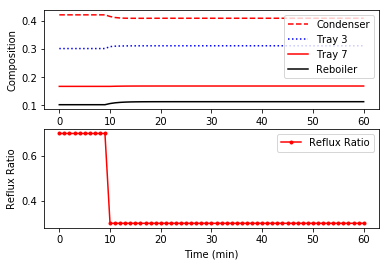

0.41010709719


In [57]:
plt.subplot(2,1,1)
plt.plot(m.time,x[0].value,'r--',label='Condenser')
plt.plot(m.time,x[3].value,'b:',label='Tray 3')
#plt.plot(m.time,x[4].value,'g--',label='Tray 4')
plt.plot(m.time,x[7].value,'r-',label='Tray 7')
#plt.plot(m.time,x[8].value,'y-',label='Tray 8')
#plt.plot(m.time,x[10].value,'b-',label='Tray 10')
plt.plot(m.time,x[11].value,'k-',label='Reboiler')
plt.ylabel('Composition')
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.plot(m.time,rr.value,'r.-',label='Reflux Ratio')
plt.ylabel('Reflux Ratio')
plt.legend(loc='upper right')

plt.xlabel('Time (min)')
plt.show()
print(x[0].value[-1])